In [1]:
import numpy
from scipy import linalg, special
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import pyplot

from tqdm.notebook import tqdm

import joblib

from born_markov import *

In [2]:
omega = 0.2 # eV
lamda = 0.4 # eV
e_0 = 0.3 + (lamda**2/omega) # eV
N = 10
Gamma = 0.01 # eV
T = 100 # K
voltage = .2


#solver = create_holstein_solver(e_0, omega, lamda, N, Gamma, -0.5*voltage, 0.5*voltage, T, T, use_exp=False)


#rho_ss, L = solver.find_steady_state()
#print(1e3*numpy.array(solver.get_current(rho_ss)))


solver2 = create_holstein_solver_via_diagonalization(e_0, omega, lamda, N, Gamma, -0.5*voltage, 0.5*voltage, T, T)


rho_ss, L = solver2.find_steady_state()
print(1e3*numpy.array(solver2.get_current(rho_ss)))

[-0.53968552+0.j  0.53968552+0.j]


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


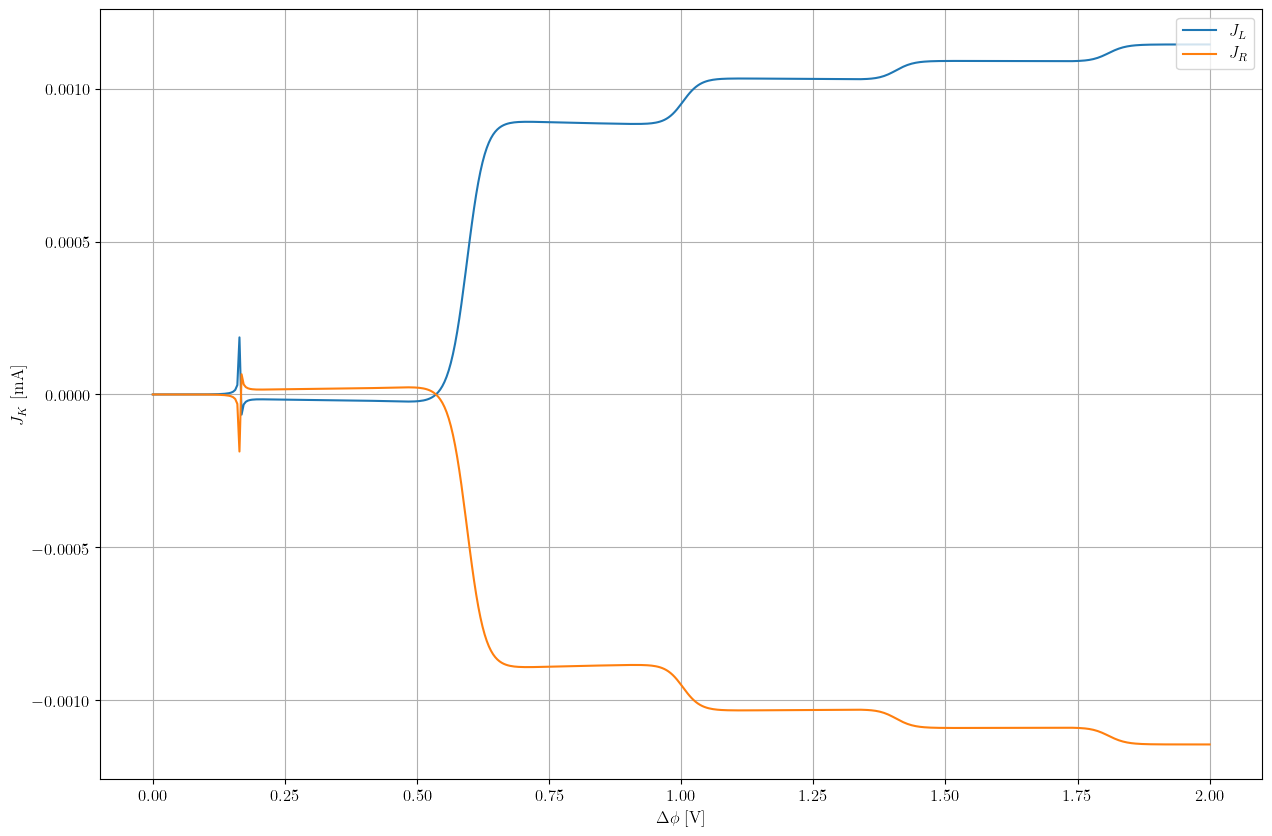

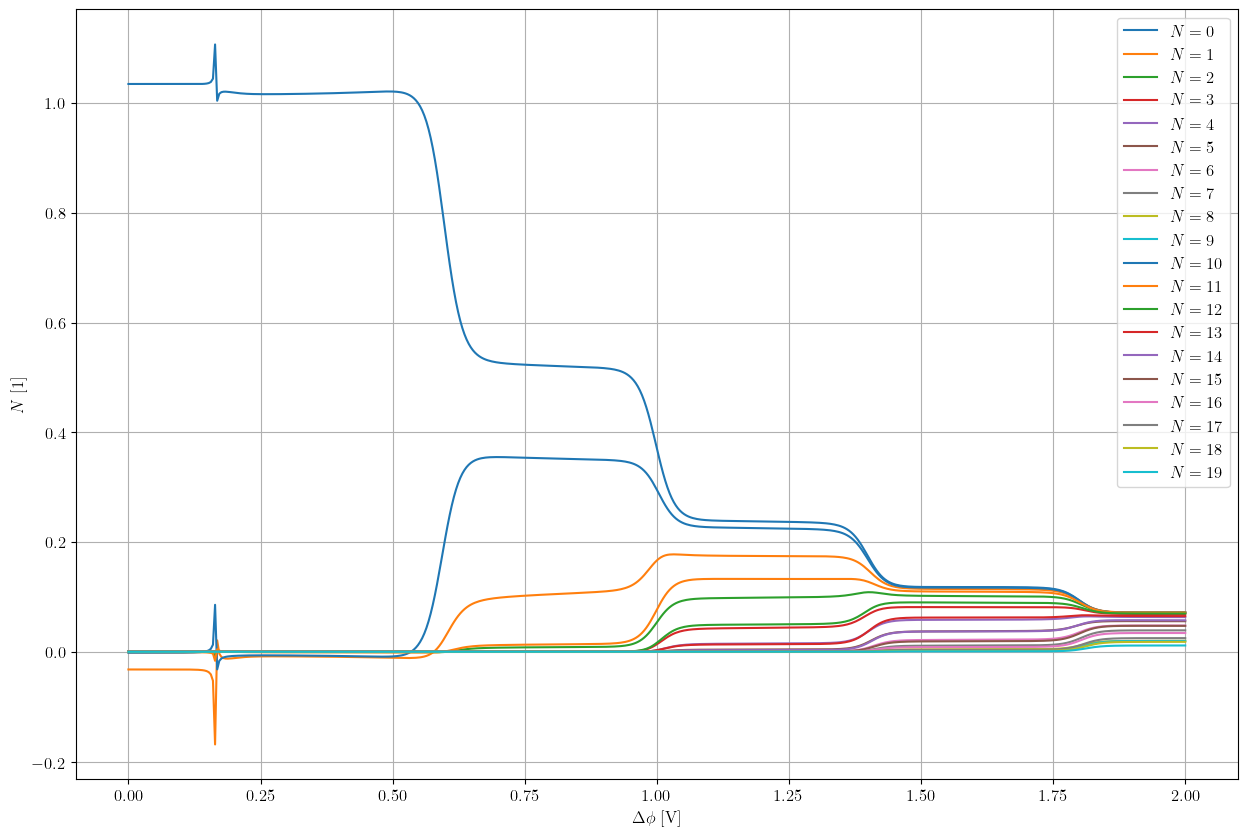

In [5]:

omega = 0.2 # eV
lamda = 0.12 # eV
e_0 = 0.3 + (lamda**2/omega) # eV
N = 20
Gamma = 0.01 # eV
T = .026 / 3 # eV
voltages = numpy.linspace(0., 2., 501)

def my_func(i, voltage):
    solver = create_holstein_solver(e_0, omega, lamda, N, Gamma, -0.5*voltage, 0.5*voltage, T, T, use_exp=True, include_digamma=True)
    rho_ss, L = solver.find_steady_state()
    return (solver.get_current(rho_ss), numpy.diag(rho_ss)[::2] + numpy.diag(rho_ss)[1::2])

results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func)(i, voltage) for i, voltage in enumerate(tqdm(voltages)))

currents = numpy.zeros((len(voltages), 2))
occupations = numpy.zeros((len(voltages), N))

for i, voltage in enumerate(voltages):
    currents[i] = results[i][0]
    occupations[i] = results[i][1]

#for i, voltage in enumerate(tqdm(voltages)):
    
    
pyplot.figure(figsize=(15,10))
pyplot.plot(voltages, currents[:,0], label="$J_L$")
pyplot.plot(voltages, currents[:,1], label="$J_R$")

pyplot.grid()
pyplot.legend(loc=1)
pyplot.xlabel("$\\Delta\\phi$ [V]")
pyplot.ylabel("$J_K$ [mA]")
pyplot.show()

pyplot.figure(figsize=(15,10))
for i in range(N):
    pyplot.plot(voltages, occupations[:,i], label="$N="+str(i)+"$")

pyplot.grid()
pyplot.legend(loc=1)
pyplot.xlabel("$\\Delta\\phi$ [V]")
pyplot.ylabel("$N$ [1]")
pyplot.show()

#numpy.save("data/holstein/HOLc_0.12_100K", currents)
#numpy.save("data/holstein/HOLo_0.12_100K", occupations)

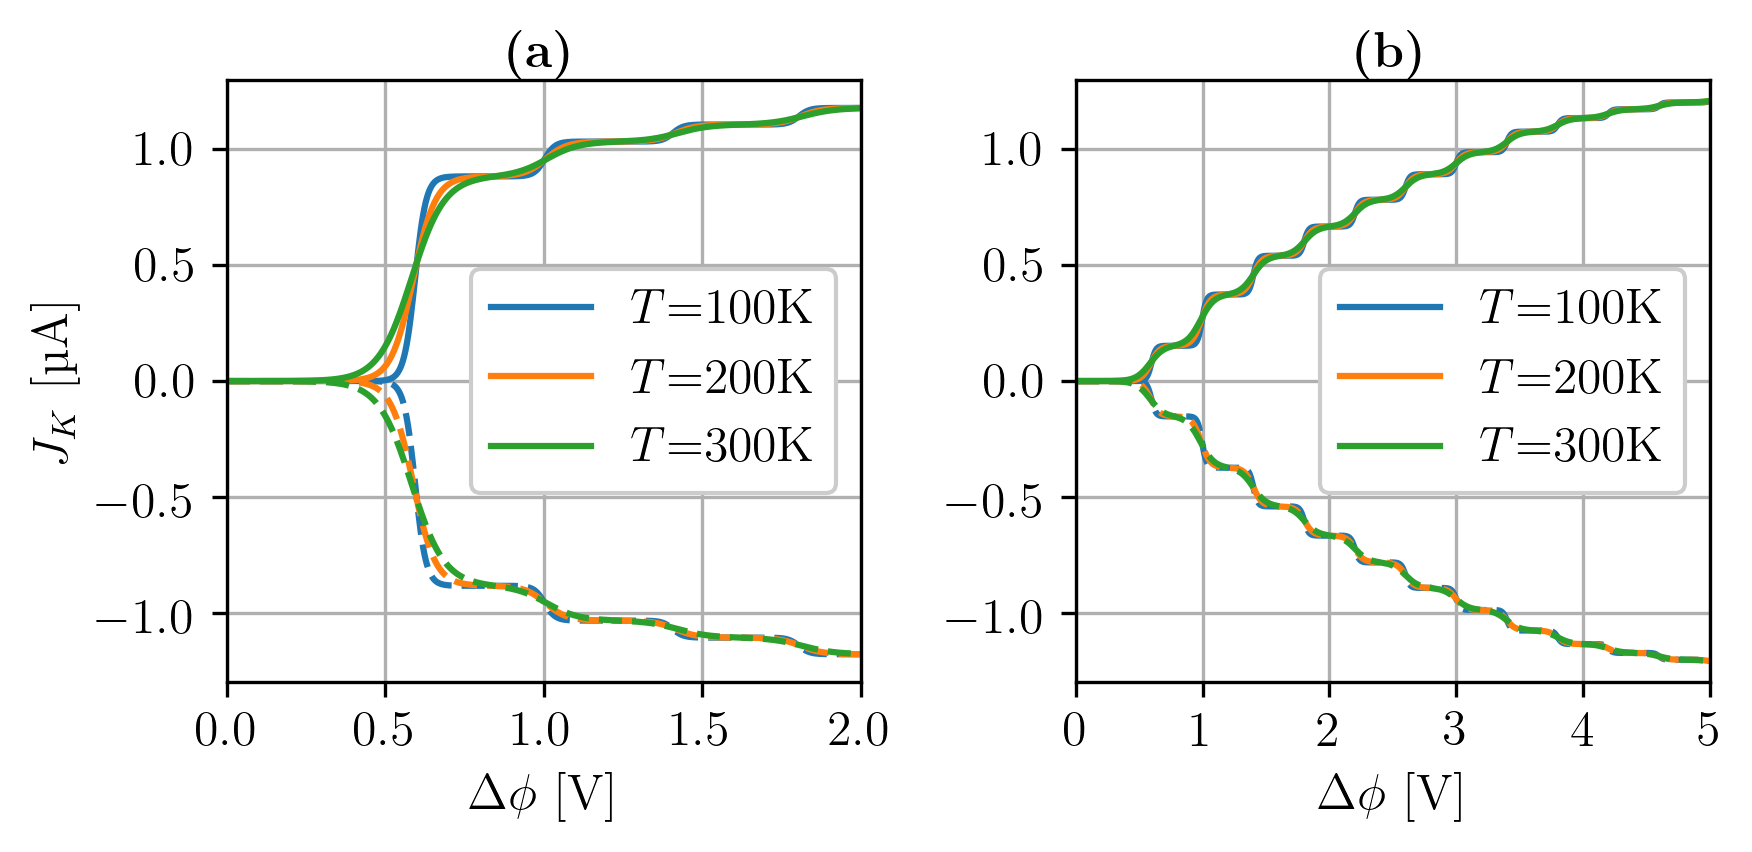

In [37]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(6,3), tight_layout=True)

voltages = numpy.linspace(0., 2., 501)

curr_12_100 = 1e3*numpy.load("data/holstein/HOLc_0.12_100K.npy")
curr_12_200 = 1e3*numpy.load("data/holstein/HOLc_0.12_200K.npy")
curr_12_300 = 1e3*numpy.load("data/holstein/HOLc_0.12_300K.npy")
curr_4_100 = 1e3*numpy.load("data/holstein/HOLc_0.4_100K.npy")
curr_4_200 = 1e3*numpy.load("data/holstein/HOLc_0.4_200K.npy")
curr_4_300 = 1e3*numpy.load("data/holstein/HOLc_0.4_300K.npy")

ax1.plot(voltages, curr_12_100[:,0], label="$T$=100K", c="tab:blue")
ax1.plot(voltages, curr_12_100[:,1], c="tab:blue", ls="--")
ax1.plot(voltages, curr_12_200[:,0], label="$T$=200K", c="tab:orange")
ax1.plot(voltages, curr_12_200[:,1], c="tab:orange", ls="--")
ax1.plot(voltages, curr_12_300[:,0], label="$T$=300K", c="tab:green")
ax1.plot(voltages, curr_12_300[:,1], c="tab:green", ls="--")
ax1.grid()
ax1.legend(loc=5, framealpha=1.)
ax1.set_xlabel("$\\Delta\\phi$ [V]")
ax1.set_xlim(.0, 2.)
ax1.set_ylabel("$J_K$ [µA]")
ax1.set_ylim(-1.3, 1.3)
ax1.text(1., 1.3, "\\textbf{(a)}", ha="center", va="bottom")

voltages = numpy.linspace(0., 5., 501)

ax2.plot(voltages, curr_4_100[:,0], label="$T$=100K", c="tab:blue") 
ax2.plot(voltages, curr_4_100[:,1], c="tab:blue", ls="--")
ax2.plot(voltages, curr_4_200[:,0], label="$T$=200K", c="tab:orange")
ax2.plot(voltages, curr_4_200[:,1], c="tab:orange", ls="--")
ax2.plot(voltages, curr_4_300[:,0], label="$T$=300K", c="tab:green")
ax2.plot(voltages, curr_4_300[:,1], c="tab:green", ls="--")
ax2.grid()
ax2.legend(loc=5, framealpha=1.)
ax2.set_xlabel("$\\Delta\\phi$ [V]")
ax2.set_xlim(.0, 5.)
ax2.set_xticks([0., 1., 2., 3., 4., 5.])
#ax2.set_ylabel("$J_K$ [µA]")
ax2.set_ylim(-1.3, 1.3)
ax2.text(2.5, 1.3, "\\textbf{(b)}", ha="center", va="bottom")

pyplot.savefig("HOL_currents.pdf")
pyplot.gcf().set_dpi(300)
pyplot.show()

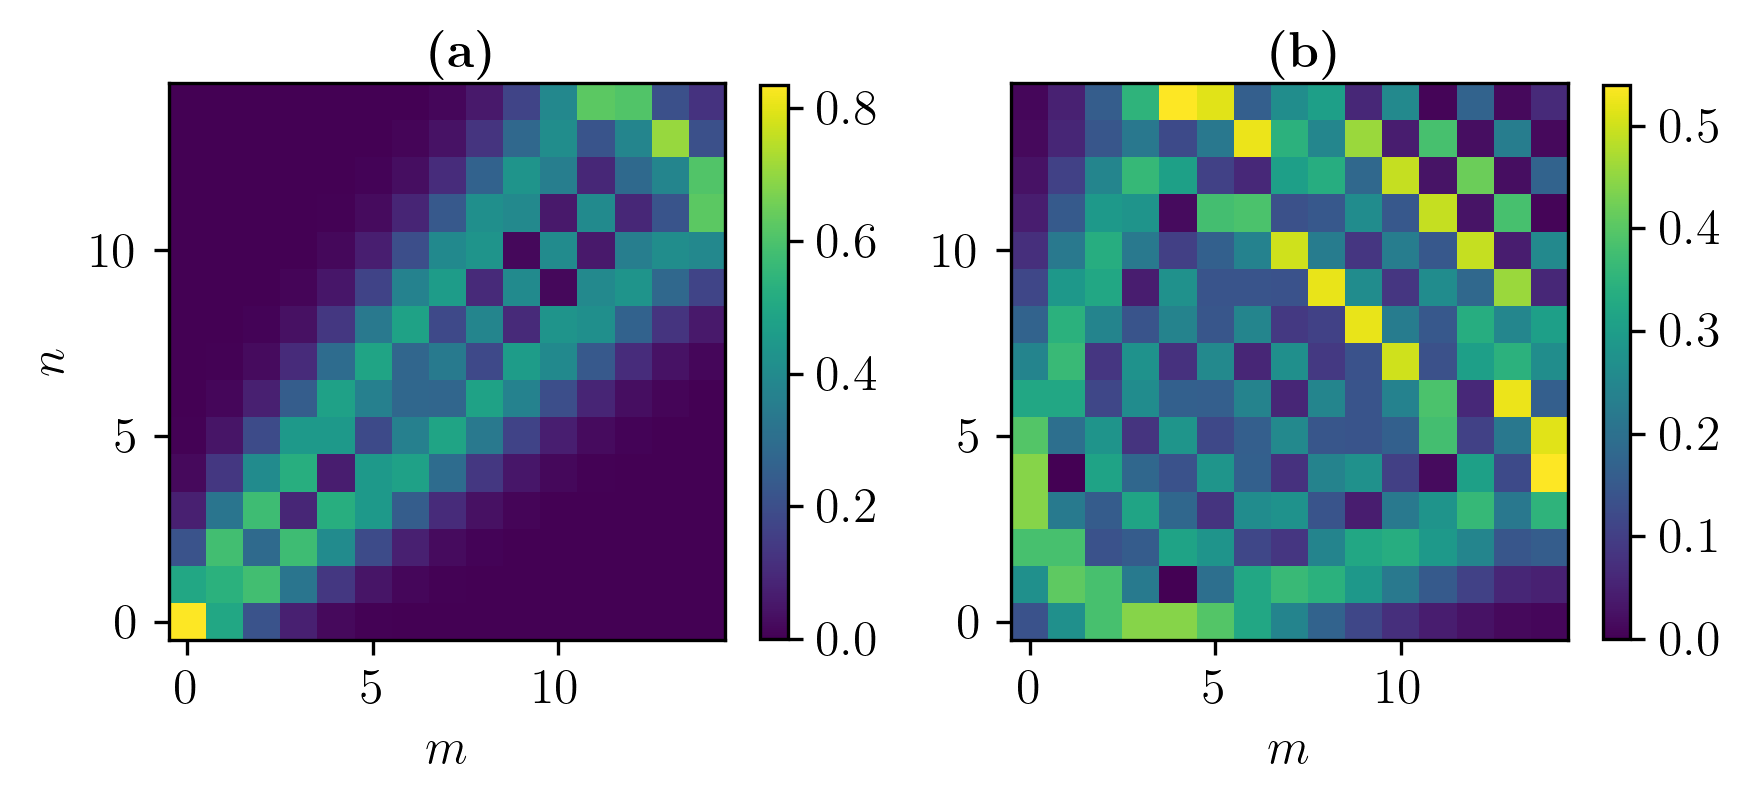

In [36]:
def FC_plus(N, lamda, omega):
    a_op = numpy.diag(numpy.sqrt(numpy.arange(1, N)), k=1)
    a_dag = numpy.transpose(a_op)
    return linalg.expm((lamda/omega) * (a_dag - a_op))

def FC_minus(N, lamda, omega):
    a_op = numpy.diag(numpy.sqrt(numpy.arange(1, N)), k=1)
    a_dag = numpy.transpose(a_op)
    return linalg.expm((lamda/omega) * (a_op - a_dag))

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(6,3), tight_layout=True)

pos1 = ax1.imshow(abs(FC_plus(15, .12, .2)), origin="lower")
ax1.set_xlabel("$m$")
ax1.set_ylabel("$n$")
ax1.text(7.5, 14.6, "\\textbf{(a)}", ha="center", va="bottom")
cb1 = fig.colorbar(pos1, ax=ax1, shrink=.73)
cb1.ax.set_yticks([.0, .2, .4, .6, .8])

pos2 = ax2.imshow(abs(FC_plus(15, .4, .2)), origin="lower")
ax2.set_xlabel("$m$")
ax2.text(7.5, 14.6, "\\textbf{(b)}", ha="center", va="bottom")
cb2 = fig.colorbar(pos2, ax=ax2, shrink=.73)
cb2.ax.set_yticks([.0, .1, .2, .3, .4, .5])

pyplot.savefig("HOL_franckcondon.pdf")
pyplot.gcf().set_dpi(300)
pyplot.show()